In [1]:
import math
import pandas as pd
from scipy.optimize import minimize_scalar
#data
L= 0.3 # module length in meters
n_f = 6 #number of fibers
i_d = 1.27e-3#internal diameter m
p_s = 0.1e-6 #pore size in meters
T = 298 #K
gamma_w = 32400#shear rate s-1
phi_m = 0.68
eta_0 = 0.000905#Pa.second viscosity of hte TGM
rho_p = 1300 #kg/m3 density of the particles
rho_f = 1000 #kg/m3 density of the fluid
k_B = 1.38064852e-23 #J/mol/K Boltzmann constant
phi_w_guess = [0.64,0.64,0.64] #guess for the volume fraction of solute at the membrane wall
# Particle sizes (in meters)
particles = [
    {'name': '10nm', 'radius': 10e-9, 'phi_b': 0.01},
    {'name': '180nm', 'radius': 180e-9, 'phi_b': 0.05},
    {'name': '300nm', 'radius': 300e-9, 'phi_b': 0.06}
]
phi_w_dict={key:values for key, values in zip([particle['radius'] for particle in particles], phi_w_guess)}
target_species = 10e-9 
#equations
#Step 2 - evaluate the viscosity
    # no particle-particle interactions - dillute suspensions
def viscosity_no_PP(eta_0,phi_b,k1):
    """eta_0 - viscosity of the dispersion medium
    phi - volume in parts occupied by the dispersed solid
    k1 = shape factor"""
    eta_phi = eta_0*(1+5/2*phi_b+k1*phi_b**2)
    return eta_phi
eta_f = viscosity_no_PP(eta_0,sum(particles['phi_b'] for particles in particles),10)
# print(eta_f)

diffusion_coeff = (k_B * T) / (6 * math.pi * eta_f * target_species)


#k1 around 10 for spheres
#not sure about the shape factor

def max_agg_packing (phi_m):
    phi_Max=phi_m+0.74*(1-phi_m)
    return phi_Max
phi_M = max_agg_packing(phi_m)
# phi_M = 0.92

#step 3 - maximum back-transport velocity, u (m/s)- Brownian, shear-infuced and intertial lift - Full retention of all solutes
 #particle volume franction at the membrane wall for each particle size for the first iteration
#J_flux = 30 #LMH


def J_brownian(a, phi_w, phi_b):
    numerator = gamma_w * (k_B ** 2) * (T ** 2)
    denominator = (eta_f ** 2) * (a ** 2) * L
    term = (numerator / denominator) ** (1/3)
    J = 0.114 * term * math.log(phi_w / phi_b)
    return J

# Function to calculate J for shear-induced diffusion
def J_shear(a, phi_w, phi_b):
    term = (a ** 4 / L) ** (1/3)
    log_term = math.log(phi_w / phi_b)
    J = 0.078 * term * gamma_w * abs(log_term)
    return J

# Function to calculate J for inertial lift
def J_inertial(a):
    J = (0.036 * rho_p * (a ** 3) * (gamma_w ** 2)) / eta_f
    return J
#J solvent permeation flux (m/s)


set_data = pd.DataFrame(columns=['name', 'radius', 'max_velocity', 'source'])

def min_flux(Particles, phi_w_list):
    """ have to put particles list with radius and phi_b,
    phi_w_list with phi_w
    results ai_target, J_flux and dataframe"""
    
    min_velocity = float('inf')
    selected_particle_radius = None
    velocities_list=[]

    for particle, phi_w in zip(Particles, phi_w_list):
        a = particle['radius']
        phi_b = particle['phi_b']
        
        # Calculate velocities
        brownian_velocity = J_brownian(a, phi_w, phi_b)
        shear_velocity = J_shear(a, phi_w, phi_b)
        inertial_velocity = J_inertial(a)
        
        # Find the maximum velocity
        max_velocity = max(brownian_velocity, inertial_velocity, shear_velocity)
        
        # Determine the source of the maximum velocity
        source = 'brownian' if max_velocity == brownian_velocity else 'inertial' if max_velocity == inertial_velocity else 'shear'
        
        # Update set_data by replacing previous row or adding a new one
        if particle['name'] in set_data['name'].values:
            set_data.loc[set_data['name'] == particle['name'], ['radius', 'max_velocity', 'source']] = [a, max_velocity, source]
        else:
            set_data.loc[len(set_data)] = [particle['name'], a, max_velocity, source]
        # Store all velocities in the DataFrame
        velocities_list.append({
            'name': particle['name'],
            'radius': a,
            'brownian_velocity': brownian_velocity,
            'shear_velocity': shear_velocity,
            'inertial_velocity': inertial_velocity
        })
        velocities_df=pd.DataFrame(velocities_list)
        # Check for the minimum velocity
        if max_velocity < min_velocity:
            min_velocity = max_velocity
            selected_particle_radius = a

    return selected_particle_radius, min_velocity, set_data,velocities_df

# Initialize variables for particles and inertial-lift properties
# ai_target, min_vel, dataf= min_flux(particles, phi_w_guess)

# Function to calculate φ_w for each particle size
def calculate_phi_w(Particles, a_target, min_velocity, data):
    count = 0
    # Dictionaries to store results
    phi_w_J_dict = {}
    phi_wjI_dict = {}
    inertial_particles = []
    
    for particle in Particles:
        a_particle = particle['radius']
        phi_b_particle = particle['phi_b']
        
        if a_particle != a_target:
            # Retrieve the velocity source from the data DataFrame
            source = data.loc[data['radius'] == a_particle, 'source'].values[0]
            
            # Use the source to choose the max_velocity
            if source == 'inertial':
                max_velocity = J_inertial(a_particle)
            elif source == 'shear':
                max_velocity = J_shear(a_particle, phi_w_dict.get(a_particle, 0.64), phi_b_particle)
            elif source == 'brownian':
                max_velocity = J_brownian(a_particle, phi_w_dict.get(a_particle, 0.64), phi_b_particle)
            else:
                raise ValueError(f"Unknown source {source} for particle {a_particle}")

            if max_velocity >= 10 * min_velocity and source == 'inertial':
                # Handle inertial particles
                phi_wjI = 0
                phi_wjI_dict[a_particle] = phi_wjI
                phi_w_dict[a_particle] = phi_wjI
                phi_w_J_dict[a_particle] = phi_wjI
                inertial_particles.append((a_particle, phi_b_particle, max_velocity))
            elif source == "inertial":
                count += 1
            elif source =="brownian" or source =="shear":
                # Define the objective function based on the source
                def objective_function(phi_w_particle):
                    # Recalculate velocities based on the current wall concentration phi_w_particle
                    if source == 'brownian':
                        max_velocity = J_brownian(a_particle, phi_w_particle, phi_b_particle)
                    elif source == 'shear':
                        max_velocity = J_shear(a_particle, phi_w_particle, phi_b_particle)
                    # elif source == 'inertial':
                    #     max_velocity = J_inertial(a_particle)
                    return abs(max_velocity - min_velocity)

                # Minimize the objective function to find the optimal phi_w for the particle
                result = minimize_scalar(objective_function, bounds=(0, 0.64), method='bounded')

                if result.success:
                    phi_w_optimal = result.x
                    phi_w_dict[a_particle] = phi_w_optimal
                    phi_w_J_dict[a_particle] = phi_w_optimal
                else:
                    print(f"Optimization failed for particle radius {a_particle:.1e} m")
    
    # Handle inertial particles after processing all particles
    if count == 1:
        for a, phi_b, u_j in inertial_particles:
            if phi_w_J_dict[a]!=0:
                phi_wjI = phi_M - sum(phi_w_J_dict.values())
                phi_wjI_dict[a] = phi_wjI
                phi_w_dict[a] = phi_wjI
    elif count > 1:
        total_u_j_inv = sum((phi_b / u_j) for _, phi_b, u_j in inertial_particles)
        phi_w_remaining = phi_M - sum(phi_w_J_dict.values())
        phi_w_jI_sum = sum((phi_b / u_j) / total_u_j_inv * phi_w_remaining for _, phi_b, u_j in inertial_particles)
        if abs(phi_M - (sum(phi_w_J_dict.values()) + phi_w_jI_sum)) > 1e-6:
            print("Warning: φ_M and the sum of φ_w_j do not match closely enough.")
        
        for a, phi_b, u_j in inertial_particles:
            phi_wjI = (phi_b / u_j) / total_u_j_inv * phi_w_remaining
            phi_wjI_dict[a] = phi_wjI
            phi_w_dict[a] = phi_wjI

    return phi_w_dict


# Output the updated dictionary
#print(f"Updated phi_w_dict: {phi_w_dict}")
def packing_constraints(Particles, phi_w_list):
    ai_target, min_vel, dataf,vel= min_flux(Particles, phi_w_list)
    phi_w_updated=calculate_phi_w(Particles, ai_target, min_vel, dataf)
    
    tolerance = 1e-6  # Set a tolerance for convergence
    max_iterations = 1000

    for i in range(max_iterations):
        remaining_phiw_j = {a: phi_w for a, phi_w in phi_w_updated.items() if a != min(phi_w_updated.keys())}
        phi_w_i = phi_w_updated[ai_target] # Wall concentration of the target particle
        # Check if packing constraints are satisfied
        if (phi_M >= sum(phi_w_updated.values())) and (sum(remaining_phiw_j.values()) <= 0.68) and phi_w_updated[min(phi_w_updated.keys())] <= 0.74 * (1 - sum(remaining_phiw_j.values())) and phi_smallest_int<0.74:
            # print(f"Iteration {i}: Packing constraints are met.")
            return phi_w_updated,   min_vel, ai_target, dataf,r_minimum, phi_smallest_int
        
        # Store the previous values of phi_w for comparison
        phi_w_previous = phi_w_updated.copy()
        # Update phi_w for the target particle
        phi_w_i_corrected = phi_M * (phi_w_i / sum(phi_w_updated.values()))
        phi_w_updated[ai_target] = phi_w_i_corrected
        phi_w_updated_list = list(phi_w_updated.values())
        #print(phi_w_updated, J_flux, a_target)
        # Recalculate the flux and phi_w_j values after updating
        _, min_vel, dataf,vel= min_flux(particles, phi_w_updated_list)
        phi_w_updated=calculate_phi_w(particles, ai_target, min_vel, dataf)
        phi_smallest_int= phi_w_updated[min(phi_w_updated.keys())] / (1 -sum(phi_w for phi_w in phi_w_updated.values() if phi_w != phi_w_updated[min(phi_w_updated.keys())]))
#        
#       # #step - 9 - calculate the minimum
        r_minimum = (min(phi_w_updated.keys()) * ( (math.sqrt(2) * ((( 4 * (4 / 3) * math.pi ) / phi_smallest_int )) ** (1/3)) - 2 ))/2
        
        # Check for the change in phi_w values between iterations
        phi_w_diff = sum(abs(phi_w_updated[a] - phi_w_previous[a]) for a in phi_w_updated)

        # If the change in phi_w values is smaller than the tolerance, stop the iteration
        if phi_w_diff < tolerance:
            # print(f"Iteration {i}: Will not converger further.")
            return phi_w_updated,   min_vel, ai_target, dataf,r_minimum, phi_smallest_int
    # If the loop completes without finding a solution
    # print("Warning: No solution found within the iteration limit.")
  
    return phi_w_updated, min_vel, ai_target, dataf,r_minimum, phi_smallest_int

#mass-transfer coefficient calculated from equation  1#step 10


def sieving_parameters(Particles, phi_w_list):
    phi_w_updated, J_flux, ai_target, dataf, r_min, phi_smal_int = packing_constraints(Particles, phi_w_list)
    # print(f"Updated phi_w_dict: {phi_w_updated}. J_flux: {J_flux}", f"ai_target: {ai_target}")
    # print(dataf)
    # print(f"phi_smallest_int: {phi_smal_int:.6f}")
    # print(f"Minimum transmission gap {min(phi_w_updated.keys())}: {r_min} m")
    

    # for i in range(50):
    Q=J_flux *n_f*math.pi*i_d*(L+L/20)
    mass_transfer_k = 1.62 * (diffusion_coeff/i_d)*(((4*rho_f*Q)/(math.pi*n_f*i_d*eta_f))**(1/3))*((eta_f/(rho_f*diffusion_coeff))**(1/3))
    # print(f"mass transfer coefficient: {mass_transfer_k}")
    lambda_s_min = target_species / r_min
    # print(f"lambda_s_min: {lambda_s_min}")
    Sieving_coeff_int = ((1 - lambda_s_min) ** 2) * (2 - ((1 - lambda_s_min) ** 2)) * math.exp(-0.7146 * (lambda_s_min ** 2))
    # print(f"Initial Sieving coefficient: {Sieving_coeff_int}")
    delta_m = target_species * ((4 * (4 / 3) * math.pi) / phi_smal_int) ** (1 / 3)
    # print(f"delta_m: {delta_m}")
    phi_e_K_d = (1 - lambda_s_min) ** (9 / 2)
    # print(f"phi_e_K_d: {phi_e_K_d}")
    cake_membrane_porosity = 1 - phi_smal_int
    # print  (f"cake_membrane_porosity: {cake_membrane_porosity}")
    Peclet_m = ((J_flux * delta_m) / diffusion_coeff) * (Sieving_coeff_int / (cake_membrane_porosity * phi_e_K_d))
    
    # print  (f"Peclet_m: {Peclet_m}")
    Sieving_coeff_act = (Sieving_coeff_int * math.exp(Peclet_m)) / ((Sieving_coeff_int + math.exp(Peclet_m)) - 1)
    #
    Sieving_coeff_obs = Sieving_coeff_act / ((1 - Sieving_coeff_act) * math.exp(-J_flux / mass_transfer_k) + Sieving_coeff_act)
    # print(f"Sieving coefficient: {Sieving_coeff_obs}")
    yields = 1 - math.exp(-4 * (Sieving_coeff_obs))
    # print(f"Yields: {yields}")
            
    return dataf, phi_w_updated,yields,J_flux 
     
        
   

sieving_parameters(particles, phi_w_guess)


(    name        radius  max_velocity    source
 0   10nm  1.000000e-08      0.000010  brownian
 1  180nm  1.800000e-07      0.000008     shear
 2  300nm  3.000000e-07      0.000010     shear,
 {1e-08: np.float64(0.27214727814831186),
  1.8e-07: np.float64(0.43505580274044814),
  3e-07: np.float64(0.17932124708245195)},
 0.2936222638889656,
 8.300603291683584e-06)

In [13]:
data_figs = pd.DataFrame(columns=['shear_rate', 'J_pred_10', "J_pred_180", "J_pred_300", "J_flux", 'yield', 'phi_w_10', 'phi_w_180', 'phi_w_300'])
gamma_w_list = range(20000, 90000, 500)

for i in range(len(gamma_w_list)):
    phi_w_dict = {key: values for key, values in zip([particle['radius'] for particle in particles], phi_w_guess)}
    gamma_w = gamma_w_list[i]  # shear rate s-1
    L = 0.3
    try:
        data_F, phi_w_dict, Yield, J_flux = sieving_parameters(particles, phi_w_guess)
        data_figs.loc[i] = [gamma_w, data_F.loc[0, 'max_velocity'], data_F.loc[1, 'max_velocity'], data_F.loc[2, 'max_velocity'], J_flux, Yield, phi_w_dict[10e-9], phi_w_dict[180e-9], phi_w_dict[300e-9]]
    except (ValueError, ZeroDivisionError, OverflowError) as e:
        pass
       

data_figs.to_csv('Data/data_figs.csv', index=False)


   

/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_63445/3202629685.py:269: RuntimeWarning: invalid value encountered in scalar power
  phi_e_K_d = (1 - lambda_s_min) ** (9 / 2)
/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_63445/3202629685.py:269: RuntimeWarning: invalid value encountered in scalar power
  phi_e_K_d = (1 - lambda_s_min) ** (9 / 2)
/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_63445/3202629685.py:269: RuntimeWarning: invalid value encountered in scalar power
  phi_e_K_d = (1 - lambda_s_min) ** (9 / 2)
/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_63445/3202629685.py:269: RuntimeWarning: invalid value encountered in scalar power
  phi_e_K_d = (1 - lambda_s_min) ** (9 / 2)
/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_63445/3202629685.py:269: RuntimeWarning: invalid value encountered in scalar power
  phi_e_K_d = (1 - lambda_s_min) ** (9 / 2)
/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_63445/32026

In [14]:
data_fig_1=data_figs


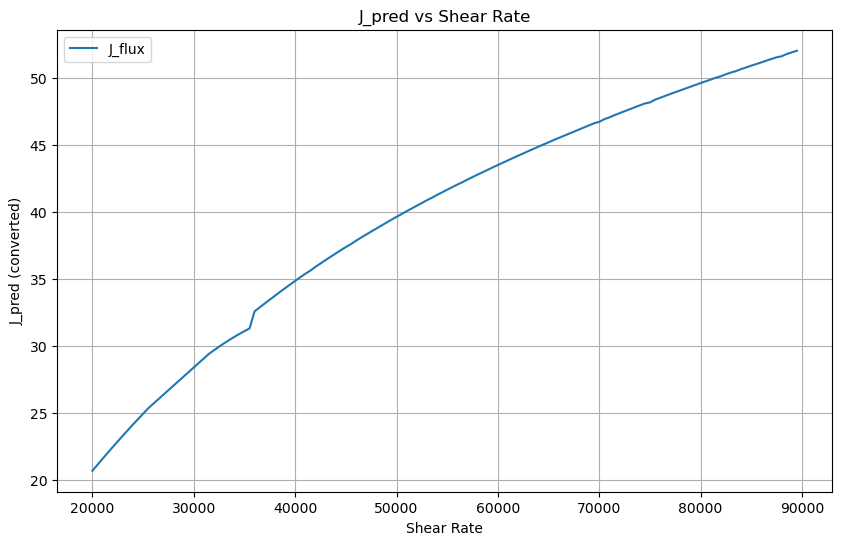

In [15]:


import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
# plt.plot(data_figs['shear_rate'], data_figs['J_pred_10'], label='J_pred_10')
plt.plot(data_figs['shear_rate'], data_figs['J_flux']*3600 * 1000, label='J_flux')
# plt.plot(data_figs['shear_rate'], data_figs['J_pred_300'], label='J_pred_300')
plt.xlabel('Shear Rate')
plt.ylabel('J_pred (converted)')
plt.title('J_pred vs Shear Rate')
plt.legend()
plt.grid(True)
plt.show()

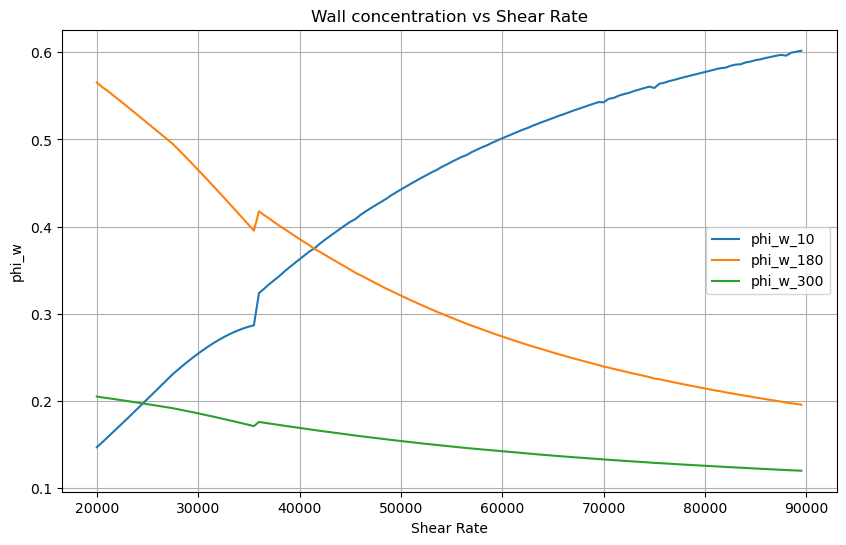

In [ ]:


plt.figure(figsize=(10, 6))
plt.plot(data_fig_1['shear_rate'], data_fig_1['phi_w_10'], label='phi_w_10')
plt.plot(data_fig_1['shear_rate'], data_fig_1['phi_w_180'], label='phi_w_180')
plt.plot(data_fig_1['shear_rate'], data_fig_1['phi_w_300'], label='phi_w_300')

plt.xlabel('Shear Rate')
plt.ylabel('phi_w')
plt.title('Wall concentration vs Shear Rate')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
data_figs_2=pd.DataFrame(columns=['shear_rate', 'J_pred_10',"J_pred_180","J_pred_300"])              
for i in range(len(gamma_w_list)):
    phi_w_dict={key:values for key, values in zip([particle['radius'] for particle in particles], phi_w_guess)}
    gamma_w = gamma_w_list[i] #shear rate s-1

    a_T, min_J, set_datas,vel_df=min_flux(particles, phi_w_guess)
    data_figs_2.loc[i] = [gamma_w, set_datas.loc[0, 'max_velocity'], set_datas.loc[1, 'max_velocity'], set_datas.loc[2, 'max_velocity']]
data_figs_2.to_csv('data_figs_2.csv', index=False)

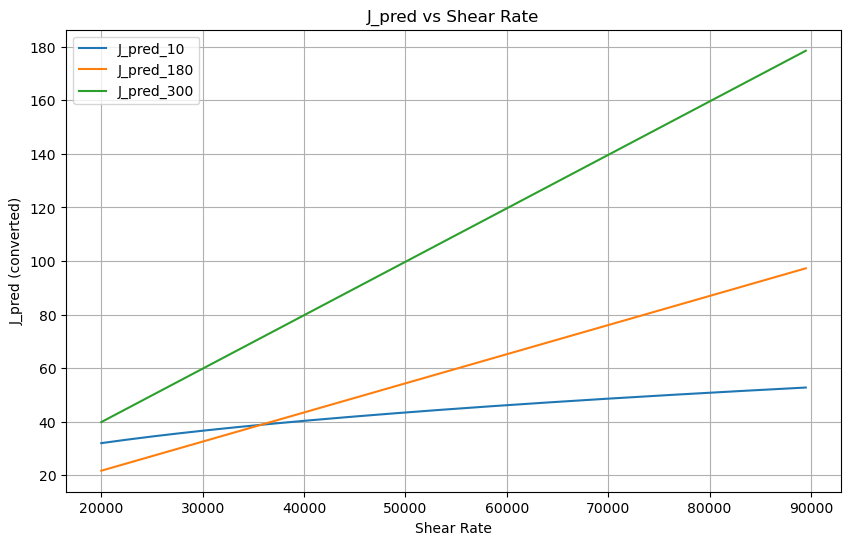

In [ ]:


plt.figure(figsize=(10, 6))
plt.plot(data_figs_2['shear_rate'], data_figs_2['J_pred_10']*3600 * 1000, label='J_pred_10')
plt.plot(data_figs_2['shear_rate'], data_figs_2['J_pred_180']*3600 * 1000, label='J_pred_180')
plt.plot(data_figs_2['shear_rate'], data_figs_2['J_pred_300']*3600 * 1000, label='J_pred_300')
plt.xlabel('Shear Rate')
plt.ylabel('J_pred (converted)')
plt.title('J_pred vs Shear Rate')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
data_figs_3=pd.DataFrame(columns=['shear_rate', 'J_pred_10',"J_pred_180","J_pred_300","J_flux",'yield', 'phi_w_10', 'phi_w_180', 'phi_w_300'])
gamma_w_list = range(20000,90000,500)
                  
for i in range(len(gamma_w_list)):
    phi_w_dict={key:values for key, values in zip([particle['radius'] for particle in particles], phi_w_guess)}
    gamma_w = gamma_w_list[i] #shear rate s-1
    L=0.1
    data_F,phi_w_dict,Yield,J_flux=sieving_parameters(particles, phi_w_guess)
    data_figs_3.loc[i] = [gamma_w, data_F.loc[0, 'max_velocity'], data_F.loc[1, 'max_velocity'], data_F.loc[2, 'max_velocity'],J_flux, Yield, phi_w_dict[10e-9], phi_w_dict[180e-9], phi_w_dict[300e-9]]

data_figs_3.to_csv('data_figs_3.csv', index=False)   

/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_63445/1471535421.py:269: RuntimeWarning: invalid value encountered in scalar power
  phi_e_K_d = (1 - lambda_s_min) ** (9 / 2)
/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_63445/1471535421.py:269: RuntimeWarning: invalid value encountered in scalar power
  phi_e_K_d = (1 - lambda_s_min) ** (9 / 2)
/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_63445/1471535421.py:269: RuntimeWarning: invalid value encountered in scalar power
  phi_e_K_d = (1 - lambda_s_min) ** (9 / 2)
/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_63445/1471535421.py:269: RuntimeWarning: invalid value encountered in scalar power
  phi_e_K_d = (1 - lambda_s_min) ** (9 / 2)
/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_63445/1471535421.py:269: RuntimeWarning: invalid value encountered in scalar power
  phi_e_K_d = (1 - lambda_s_min) ** (9 / 2)
/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_63445/14715

In [6]:

data_fig_4 = pd.DataFrame(columns=['L', 'shear_rate', 'J_pred_10', "J_pred_180", "J_pred_300", "J_flux", 'yield', 'phi_w_10', 'phi_w_180', 'phi_w_300'])
for i in range(len(gamma_w_list)):
        phi_w_dict = {key: values for key, values in zip([particle['radius'] for particle in particles], phi_w_guess)}
        gamma_w = gamma_w_list[i]  # shear rate s-1
        L=0.2
        data_F, phi_w_dict, Yield, J_flux = sieving_parameters(particles, phi_w_guess)
        data_fig_4.loc[i] = [L, gamma_w, data_F.loc[0, 'max_velocity'], data_F.loc[1, 'max_velocity'], data_F.loc[2, 'max_velocity'], J_flux, Yield, phi_w_dict[10e-9], phi_w_dict[180e-9], phi_w_dict[300e-9]]
data_fig_5 = pd.DataFrame(columns=['L', 'shear_rate', 'J_pred_10', "J_pred_180", "J_pred_300", "J_flux", 'yield', 'phi_w_10', 'phi_w_180', 'phi_w_300'])
for i in range(len(gamma_w_list)):
        phi_w_dict = {key: values for key, values in zip([particle['radius'] for particle in particles], phi_w_guess)}
        gamma_w = gamma_w_list[i]  # shear rate s-1
        L=0.4
        data_F, phi_w_dict, Yield, J_flux = sieving_parameters(particles, phi_w_guess)
        data_fig_5.loc[i] = [L, gamma_w, data_F.loc[0, 'max_velocity'], data_F.loc[1, 'max_velocity'], data_F.loc[2, 'max_velocity'], J_flux, Yield, phi_w_dict[10e-9], phi_w_dict[180e-9], phi_w_dict[300e-9]]
data_fig_6 = pd.DataFrame(columns=['L', 'shear_rate', 'J_pred_10', "J_pred_180", "J_pred_300", "J_flux", 'yield', 'phi_w_10', 'phi_w_180', 'phi_w_300'])
for i in range(len(gamma_w_list)):
        phi_w_dict = {key: values for key, values in zip([particle['radius'] for particle in particles], phi_w_guess)}
        gamma_w = gamma_w_list[i]  # shear rate s-1
        L=0.5
        data_F, phi_w_dict, Yield, J_flux = sieving_parameters(particles, phi_w_guess)
        data_fig_6.loc[i] = [L, gamma_w, data_F.loc[0, 'max_velocity'], data_F.loc[1, 'max_velocity'], data_F.loc[2, 'max_velocity'], J_flux, Yield, phi_w_dict[10e-9], phi_w_dict[180e-9], phi_w_dict[300e-9]]
               
data_fig_4.to_csv('data_figs_4.csv', index=False) 
data_fig_5.to_csv('data_figs_5.csv', index=False) 
data_fig_6.to_csv('data_figs_6.csv', index=False)    

/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_63445/1471535421.py:269: RuntimeWarning: invalid value encountered in scalar power
  phi_e_K_d = (1 - lambda_s_min) ** (9 / 2)
/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_63445/1471535421.py:269: RuntimeWarning: invalid value encountered in scalar power
  phi_e_K_d = (1 - lambda_s_min) ** (9 / 2)
/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_63445/1471535421.py:269: RuntimeWarning: invalid value encountered in scalar power
  phi_e_K_d = (1 - lambda_s_min) ** (9 / 2)
/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_63445/1471535421.py:269: RuntimeWarning: invalid value encountered in scalar power
  phi_e_K_d = (1 - lambda_s_min) ** (9 / 2)
/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_63445/1471535421.py:269: RuntimeWarning: invalid value encountered in scalar power
  phi_e_K_d = (1 - lambda_s_min) ** (9 / 2)
/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_63445/14715

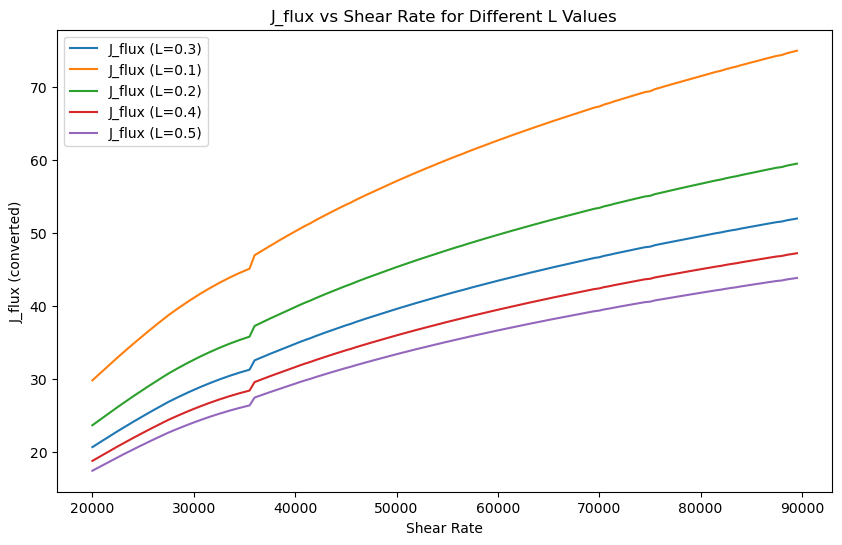

In [ ]:
plt.figure(figsize=(10, 6))

# Plot for data_figs
plt.plot(data_fig_1['shear_rate'], data_fig_1['J_flux']* 3600 * 1000, label=f'J_flux (L=0.3)')
plt.plot(data_figs_3['shear_rate'], data_figs_3['J_flux'] * 3600 * 1000, label=f'J_flux (L=0.1)')
plt.plot(data_fig_4['shear_rate'], data_fig_4['J_flux']* 3600 * 1000, label=f'J_flux (L=0.2)')
plt.plot(data_fig_5['shear_rate'], data_fig_5['J_flux']* 3600 * 1000, label=f'J_flux (L=0.4)')
plt.plot(data_fig_6['shear_rate'], data_fig_6['J_flux']* 3600 * 1000, label=f'J_flux (L=0.5)')

# Plot for each DataFrame in data_figs_dict
plt.xlabel('Shear Rate')
plt.ylabel('J_flux (converted)')
plt.title('J_flux vs Shear Rate for Different L Values')
plt.legend()

plt.show()

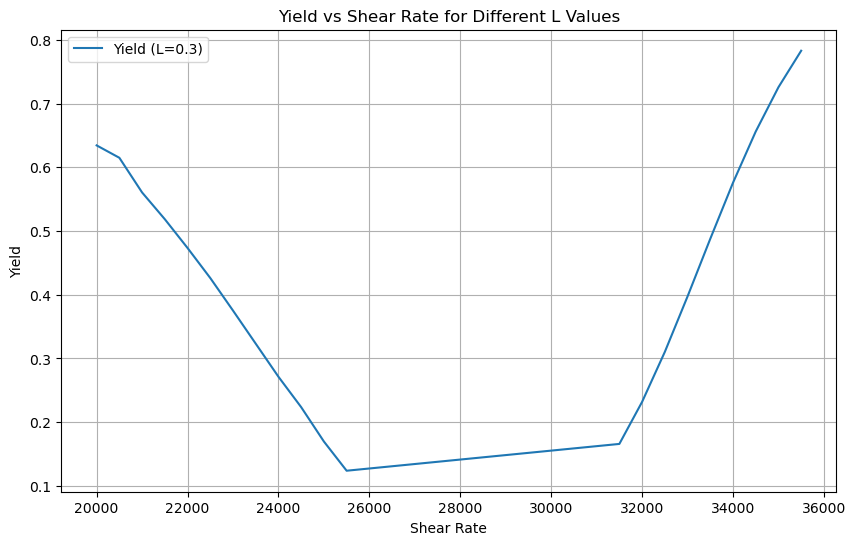

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(data_figs['shear_rate'], data_figs['yield'], label='Yield (L=0.3)')


plt.xlabel('Shear Rate')
plt.ylabel('Yield')
plt.title('Yield vs Shear Rate for Different L Values')
plt.legend()
plt.grid(True)
plt.show()

In [2]:
(0.14/0.74)-1+0.56==-(+0.2)

False

In [5]:
-((0.14/0.74)-1+0.2)


0.6108108108108108